This notebook will:

Load normalized target (and optionally source for comparison)

Compute inter-event time gaps per user (distribution/quantiles)

Produce timeline plots / daily volume (target-focused)

Identify recommended session gap threshold candidates (e.g., 30m, 1h, 6h, 1d) based on gap distribution

Still no sessionization (actual session labeling happens in Notebook 05)

Header + imports + version logging

In [1]:
# [CELL 04-00] Notebook 04 — Session gap & timeline analysis (Target-focused)
# Goal: analyze inter-event time gaps and temporal patterns to pick session gap thresholds.
# Guardrail: NO sessionization yet (no session_id assignment here).

import os
import sys
import json
import platform
from pathlib import Path
from datetime import datetime

import pandas as pd

try:
    import duckdb
except Exception as e:
    raise RuntimeError("duckdb is required for this notebook. Please install duckdb.") from e

print("[04-00] Python:", sys.version)
print("[04-00] Platform:", platform.platform())
print("[04-00] pandas:", pd.__version__)
print("[04-00] duckdb:", duckdb.__version__)
print("[04-00] CWD:", Path.cwd().resolve())


[04-00] Python: 3.11.14 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 18:30:03) [MSC v.1929 64 bit (AMD64)]
[04-00] Platform: Windows-10-10.0.22621-SP0
[04-00] pandas: 2.3.3
[04-00] duckdb: 1.4.3
[04-00] CWD: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\notebooks


Locate repo root + dirs

In [2]:
# [CELL 04-01] Bootstrap: locate repo root reliably (Windows-safe)

CWD = Path.cwd().resolve()
print("[04-01] Initial CWD:", CWD)

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "PROJECT_STATE.md").exists():
            print(f"[04-01] Found PROJECT_STATE.md in: {p}")
            return p
    for p in [start, *start.parents]:
        if (p / ".git").exists():
            print(f"[04-01] Found .git in: {p}")
            return p
    raise FileNotFoundError("Could not locate repo root (PROJECT_STATE.md or .git not found).")

REPO_ROOT = find_repo_root(CWD)

DATA_DIR      = REPO_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR   = REPO_ROOT / "reports"

print("[04-01] REPO_ROOT:", REPO_ROOT)
print("[04-01] PROCESSED_DIR:", PROCESSED_DIR)
print("[04-01] REPORTS_DIR:", REPORTS_DIR)


[04-01] Initial CWD: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\notebooks
[04-01] Found PROJECT_STATE.md in: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta
[04-01] REPO_ROOT: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta
[04-01] PROCESSED_DIR: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed
[04-01] REPORTS_DIR: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports


RUN_TAG + report dir + helpers

In [3]:
# [CELL 04-02] RUN_TAG + output dirs + helpers

RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_REPORT_DIR = REPORTS_DIR / "04_session_gap_and_timeline_analysis" / RUN_TAG
RUN_REPORT_DIR.mkdir(parents=True, exist_ok=True)

print("[04-02] RUN_TAG:", RUN_TAG)
print("[04-02] RUN_REPORT_DIR:", RUN_REPORT_DIR)

def save_json(path: Path, obj: dict):
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(obj, indent=2, ensure_ascii=False), encoding="utf-8")
    print("[04-02] Wrote JSON:", path)

def save_df_csv(path: Path, df: pd.DataFrame, index=False):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=index)
    print("[04-02] Wrote CSV:", path, "| shape:", df.shape)

run_meta = {
    "run_tag": RUN_TAG,
    "notebook": "04_session_gap_and_timeline_analysis.ipynb",
    "created_at": datetime.now().isoformat(timespec="seconds"),
    "repo_root": str(REPO_ROOT),
    "processed_dir": str(PROCESSED_DIR),
    "python": sys.version,
    "pandas": pd.__version__,
    "duckdb": duckdb.__version__,
    "platform": platform.platform(),
}
save_json(RUN_REPORT_DIR / "run_meta.json", run_meta)


[04-02] RUN_TAG: 20251229_141438
[04-02] RUN_REPORT_DIR: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438
[04-02] Wrote JSON: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\run_meta.json


Load normalized target events (CHECKPOINT)

In [4]:
# [CELL 04-03] Load normalized target events (deduped) from Notebook 03

TARGET_NORM = PROCESSED_DIR / "normalized_events" / "events_target_norm.parquet"
print("[04-03] TARGET_NORM:", TARGET_NORM)
assert TARGET_NORM.exists(), f"Missing: {TARGET_NORM}"

con = duckdb.connect(database=":memory:")
con.execute("PRAGMA threads=8;")

con.execute(f"CREATE OR REPLACE VIEW tgt AS SELECT * FROM read_parquet('{str(TARGET_NORM)}');")

schema = con.execute("DESCRIBE SELECT * FROM tgt;").df()
print("[04-03] tgt schema:")
display(schema)

sample = con.execute("SELECT * FROM tgt ORDER BY timestamp LIMIT 5;").df()
print("[04-03] tgt earliest sample:")
display(sample)

counts = con.execute("""
SELECT
  COUNT(*) AS n_events,
  COUNT(DISTINCT user_id) AS n_users,
  COUNT(DISTINCT item_id) AS n_items,
  MIN(timestamp) AS min_ts,
  MAX(timestamp) AS max_ts
FROM tgt;
""").df()
print("[04-03] tgt counts:")
display(counts)

save_df_csv(RUN_REPORT_DIR / "tgt_schema.csv", schema)
save_df_csv(RUN_REPORT_DIR / "tgt_counts.csv", counts)


[04-03] TARGET_NORM: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\normalized_events\events_target_norm.parquet
[04-03] tgt schema:


,column_name,column_type,null,key,default,extra
0,user_id,VARCHAR,YES,None,None,None
1,item_id,VARCHAR,YES,None,None,None
2,timestamp,TIMESTAMP,YES,None,None,None
3,signal_type,VARCHAR,YES,None,None,None
4,value,DOUBLE,YES,None,None,None


[04-03] tgt earliest sample:


,user_id,item_id,timestamp,signal_type,value
0,245112,32022,2018-09-28 14:38:15,explicit_rating,0.1
1,245112,32024,2018-09-28 14:38:25,explicit_rating,0.1
2,245112,32025,2018-09-28 14:42:15,explicit_rating,1.0
3,263137,43457,2018-09-28 14:44:21,explicit_rating,1.0
4,263137,43458,2018-09-28 14:49:57,explicit_rating,1.0


[04-03] tgt counts:


,n_events,n_users,n_items,min_ts,max_ts
0,3655,822,776,2018-09-28 14:38:15,2021-09-20 16:26:06


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\tgt_schema.csv | shape: (5, 6)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\tgt_counts.csv | shape: (1, 5)


Compute inter-event gaps (per user) + quantiles (CHECKPOINT)

In [5]:
# [CELL 04-04] Inter-event time gaps per user (target)
# We compute gaps only where a previous event exists (users with >=2 events contribute).

print("\n" + "="*70)
print("04-04 INTER-EVENT GAP ANALYSIS (TARGET)")
print("="*70)

# How many users have >=2 events?
users_2plus = con.execute("""
WITH per_user AS (
  SELECT user_id, COUNT(*) AS n
  FROM tgt
  GROUP BY 1
)
SELECT
  COUNT(*) AS total_users,
  SUM(CASE WHEN n >= 2 THEN 1 ELSE 0 END) AS users_2plus,
  SUM(CASE WHEN n >= 5 THEN 1 ELSE 0 END) AS users_5plus,
  SUM(CASE WHEN n >= 10 THEN 1 ELSE 0 END) AS users_10plus
FROM per_user;
""").df()

print("[04-04] Users by event count:")
display(users_2plus)

# Gap table (seconds) for all consecutive pairs per user
con.execute("""
CREATE OR REPLACE VIEW tgt_gaps AS
WITH ordered AS (
  SELECT
    user_id,
    timestamp,
    LAG(timestamp) OVER (PARTITION BY user_id ORDER BY timestamp) AS prev_ts
  FROM tgt
)
SELECT
  user_id,
  timestamp,
  prev_ts,
  EXTRACT(EPOCH FROM (timestamp - prev_ts)) AS gap_seconds
FROM ordered
WHERE prev_ts IS NOT NULL;
""")

gap_summary = con.execute("""
SELECT
  COUNT(*) AS n_gaps,
  MIN(gap_seconds) AS min_gap_s,
  MAX(gap_seconds) AS max_gap_s,
  AVG(gap_seconds) AS avg_gap_s,
  approx_quantile(gap_seconds, [0.5, 0.75, 0.9, 0.95, 0.99]) AS q
FROM tgt_gaps;
""").df()

print("[04-04] Gap summary (seconds):")
display(gap_summary)

# Convenience: same quantiles in minutes/hours/days
gap_q = con.execute("""
SELECT
  approx_quantile(gap_seconds/60.0,     [0.5, 0.75, 0.9, 0.95, 0.99]) AS q_minutes,
  approx_quantile(gap_seconds/3600.0,   [0.5, 0.75, 0.9, 0.95, 0.99]) AS q_hours,
  approx_quantile(gap_seconds/86400.0,  [0.5, 0.75, 0.9, 0.95, 0.99]) AS q_days
FROM tgt_gaps;
""").df()

print("[04-04] Gap quantiles (minutes/hours/days):")
display(gap_q)

save_df_csv(RUN_REPORT_DIR / "users_2plus_counts.csv", users_2plus)
save_df_csv(RUN_REPORT_DIR / "gap_summary_seconds.csv", gap_summary)
save_df_csv(RUN_REPORT_DIR / "gap_quantiles_converted.csv", gap_q)



04-04 INTER-EVENT GAP ANALYSIS (TARGET)
[04-04] Users by event count:


,total_users,users_2plus,users_5plus,users_10plus
0,822,426.0,164.0,73.0


[04-04] Gap summary (seconds):


,n_gaps,min_gap_s,max_gap_s,avg_gap_s,q
0,2833,1.0,73784739.0,766131.444052,"[201.20947243080363, 595.4903047091411, 173673..."


[04-04] Gap quantiles (minutes/hours/days):


,q_minutes,q_hours,q_days
0,"[3.3534725634725633, 9.91811038011696, 2873.75...","[0.055891209391209395, 0.16530183966861597, 47...","[0.002328800391300391, 0.006887576652858999, 1..."


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\users_2plus_counts.csv | shape: (1, 4)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\gap_summary_seconds.csv | shape: (1, 5)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\gap_quantiles_converted.csv | shape: (1, 3)


Gap distribution buckets + candidate thresholds

In [6]:
# [CELL 04-05] Gap bucket distribution + candidate thresholds for session boundary

print("\n" + "="*70)
print("04-05 GAP BUCKETS + THRESHOLD CANDIDATES")
print("="*70)

gap_buckets = con.execute("""
SELECT
  SUM(CASE WHEN gap_seconds <=  5*60 THEN 1 ELSE 0 END) AS le_5m,
  SUM(CASE WHEN gap_seconds <= 10*60 THEN 1 ELSE 0 END) AS le_10m,
  SUM(CASE WHEN gap_seconds <= 30*60 THEN 1 ELSE 0 END) AS le_30m,
  SUM(CASE WHEN gap_seconds <= 60*60 THEN 1 ELSE 0 END) AS le_60m,
  SUM(CASE WHEN gap_seconds <=  6*3600 THEN 1 ELSE 0 END) AS le_6h,
  SUM(CASE WHEN gap_seconds <= 12*3600 THEN 1 ELSE 0 END) AS le_12h,
  SUM(CASE WHEN gap_seconds <= 24*3600 THEN 1 ELSE 0 END) AS le_24h,
  COUNT(*) AS total_gaps
FROM tgt_gaps;
""").df()

display(gap_buckets)

row = gap_buckets.iloc[0]
total = float(row["total_gaps"]) if float(row["total_gaps"]) > 0 else 1.0

def pct(x): 
    return 100.0 * float(x) / total

print("[04-05] % of gaps within bucket:")
print(f"  <=5m : {pct(row['le_5m']):.1f}%")
print(f"  <=10m: {pct(row['le_10m']):.1f}%")
print(f"  <=30m: {pct(row['le_30m']):.1f}%")
print(f"  <=60m: {pct(row['le_60m']):.1f}%")
print(f"  <=6h : {pct(row['le_6h']):.1f}%")
print(f"  <=12h: {pct(row['le_12h']):.1f}%")
print(f"  <=24h: {pct(row['le_24h']):.1f}%")

# Suggested threshold candidates (we'll confirm after seeing quantiles + bucket curve)
threshold_candidates = pd.DataFrame({
    "threshold_name": ["10m", "30m", "60m", "6h", "12h", "24h"],
    "threshold_seconds": [10*60, 30*60, 60*60, 6*3600, 12*3600, 24*3600],
})
print("\n[04-05] Candidate thresholds:")
display(threshold_candidates)

save_df_csv(RUN_REPORT_DIR / "gap_buckets.csv", gap_buckets)
save_df_csv(RUN_REPORT_DIR / "threshold_candidates.csv", threshold_candidates)



04-05 GAP BUCKETS + THRESHOLD CANDIDATES


,le_5m,le_10m,le_30m,le_60m,le_6h,le_12h,le_24h,total_gaps
0,1819.0,2132.0,2333.0,2380.0,2472.0,2481.0,2527.0,2833


[04-05] % of gaps within bucket:
  <=5m : 64.2%
  <=10m: 75.3%
  <=30m: 82.4%
  <=60m: 84.0%
  <=6h : 87.3%
  <=12h: 87.6%
  <=24h: 89.2%

[04-05] Candidate thresholds:


,threshold_name,threshold_seconds
0,10m,600
1,30m,1800
2,60m,3600
3,6h,21600
4,12h,43200
5,24h,86400


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\gap_buckets.csv | shape: (1, 8)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\threshold_candidates.csv | shape: (6, 2)


Daily volume timeline (and save CSV)


04-06 DAILY EVENT VOLUME (TARGET)
[04-06] Daily rows: (595, 2)


,day,n
0,2018-09-28,44
1,2018-09-29,2
2,2018-10-01,1
3,2018-10-02,2
4,2018-10-04,30


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\daily_event_volume.csv | shape: (595, 2)


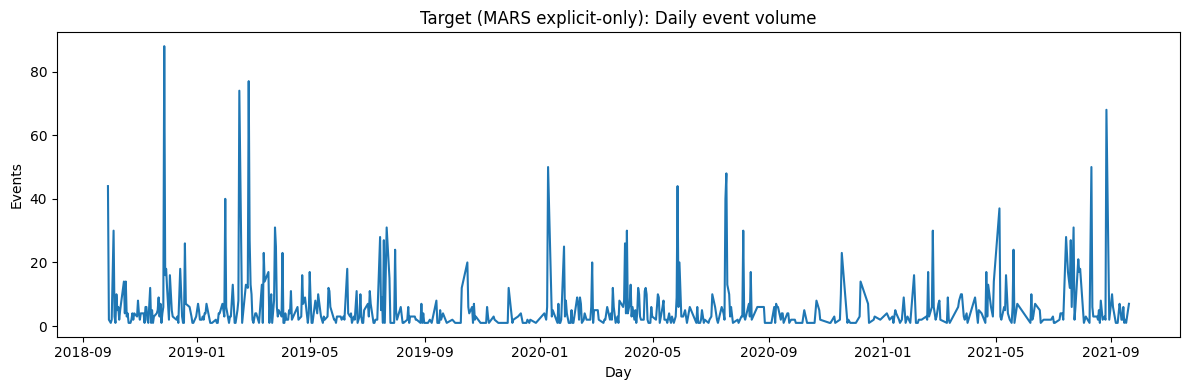

[04-06] Saved plot: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\daily_event_volume.png


In [7]:
# [CELL 04-06] Daily event volume timeline (target)

print("\n" + "="*70)
print("04-06 DAILY EVENT VOLUME (TARGET)")
print("="*70)

daily = con.execute("""
SELECT
  CAST(date_trunc('day', timestamp) AS DATE) AS day,
  COUNT(*) AS n
FROM tgt
GROUP BY 1
ORDER BY 1;
""").df()

print("[04-06] Daily rows:", daily.shape)
display(daily.head())

save_df_csv(RUN_REPORT_DIR / "daily_event_volume.csv", daily)

# Plot (matplotlib only; no custom colors)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(daily["day"], daily["n"])
plt.title("Target (MARS explicit-only): Daily event volume")
plt.xlabel("Day")
plt.ylabel("Events")
plt.tight_layout()

out_png = RUN_REPORT_DIR / "daily_event_volume.png"
plt.savefig(out_png, dpi=160)
plt.show()

print("[04-06] Saved plot:", out_png)


Per-user activity span + events per user (for “multi-session” evidence)

In [8]:
# [CELL 04-07] Per-user spans and event counts (target)

print("\n" + "="*70)
print("04-07 USER ACTIVITY SPANS (TARGET)")
print("="*70)

per_user = con.execute("""
WITH per_user AS (
  SELECT
    user_id,
    COUNT(*) AS n_events,
    MIN(timestamp) AS first_ts,
    MAX(timestamp) AS last_ts
  FROM tgt
  GROUP BY 1
)
SELECT
  approx_quantile(n_events, [0.5, 0.9, 0.99]) AS events_q,
  MIN(n_events) AS min_events,
  MAX(n_events) AS max_events,
  AVG(n_events) AS avg_events,
  approx_quantile(EXTRACT(EPOCH FROM (last_ts - first_ts)) / 86400.0, [0.5, 0.9, 0.99]) AS span_days_q,
  AVG(EXTRACT(EPOCH FROM (last_ts - first_ts)) / 86400.0) AS avg_span_days
FROM per_user;
""").df()

print("[04-07] Per-user summary:")
display(per_user)

# How many users have span >= 1 day / 7 days / 30 days?
span_buckets = con.execute("""
WITH per_user AS (
  SELECT
    user_id,
    (EXTRACT(EPOCH FROM (MAX(timestamp) - MIN(timestamp))) / 86400.0) AS span_days
  FROM tgt
  GROUP BY 1
)
SELECT
  COUNT(*) AS total_users,
  SUM(CASE WHEN span_days >= 1  THEN 1 ELSE 0 END) AS users_span_ge_1d,
  SUM(CASE WHEN span_days >= 7  THEN 1 ELSE 0 END) AS users_span_ge_7d,
  SUM(CASE WHEN span_days >= 30 THEN 1 ELSE 0 END) AS users_span_ge_30d
FROM per_user;
""").df()

print("[04-07] Users by span bucket:")
display(span_buckets)

save_df_csv(RUN_REPORT_DIR / "per_user_summary.csv", per_user)
save_df_csv(RUN_REPORT_DIR / "user_span_buckets.csv", span_buckets)



04-07 USER ACTIVITY SPANS (TARGET)
[04-07] Per-user summary:


,events_q,min_events,max_events,avg_events,span_days_q,avg_span_days
0,"[2, 8, 59]",1,134,4.446472,"[0.0007795621141975308, 44.73297549170263, 735...",30.560771


[04-07] Users by span bucket:


,total_users,users_span_ge_1d,users_span_ge_7d,users_span_ge_30d
0,822,162.0,131.0,93.0


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\per_user_summary.csv | shape: (1, 6)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\user_span_buckets.csv | shape: (1, 4)


Make the session-gap recommendation (no sessionization) + save metadata

In [9]:
# [CELL 04-08] Recommended session-gap thresholds (target) + save metadata

print("\n" + "="*70)
print("04-08 RECOMMENDED SESSION GAP THRESHOLDS")
print("="*70)

# Based on bucket curve:
# <=30m covers ~82.4% of consecutive gaps (strong candidate for within-session)
# <=60m covers ~84.0% (slightly more permissive, small gain)
# We'll recommend:
#   PRIMARY: 30 minutes
#   SENSITIVITY: 10m, 60m, 6h (for robustness checks in Notebook 05)

recommended = {
    "primary_threshold_seconds": 30 * 60,
    "primary_threshold_label": "30m",
    "sensitivity_thresholds_seconds": [10 * 60, 60 * 60, 6 * 3600],
    "sensitivity_thresholds_labels": ["10m", "60m", "6h"],
    "justification": {
        "gap_bucket_pct": {
            "le_10m": float(gap_buckets.iloc[0]["le_10m"]) / float(gap_buckets.iloc[0]["total_gaps"]),
            "le_30m": float(gap_buckets.iloc[0]["le_30m"]) / float(gap_buckets.iloc[0]["total_gaps"]),
            "le_60m": float(gap_buckets.iloc[0]["le_60m"]) / float(gap_buckets.iloc[0]["total_gaps"]),
            "le_6h":  float(gap_buckets.iloc[0]["le_6h"])  / float(gap_buckets.iloc[0]["total_gaps"]),
        },
        "users_2plus": int(users_2plus.iloc[0]["users_2plus"]),
        "total_users": int(users_2plus.iloc[0]["total_users"]),
        "n_gaps": int(gap_summary.iloc[0]["n_gaps"]),
    },
    "notes": [
        "Explicit-only target has fewer events; thresholds are chosen from observed gap distribution.",
        "No sessionization is performed in Notebook 04; session_id assignment happens in Notebook 05."
    ]
}

save_json(RUN_REPORT_DIR / "recommended_thresholds.json", recommended)

print("[04-08] Recommended primary threshold:", recommended["primary_threshold_label"], f"({recommended['primary_threshold_seconds']}s)")
print("[04-08] Sensitivity thresholds:", list(zip(recommended["sensitivity_thresholds_labels"], recommended["sensitivity_thresholds_seconds"])))



04-08 RECOMMENDED SESSION GAP THRESHOLDS
[04-02] Wrote JSON: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\recommended_thresholds.json
[04-08] Recommended primary threshold: 30m (1800s)
[04-08] Sensitivity thresholds: [('10m', 600), ('60m', 3600), ('6h', 21600)]


Source gap analysis (04B)

Load source normalized events + basic counts

In [10]:
# [CELL 04-09] Load SOURCE normalized events (deduped) from Notebook 03

print("\n" + "="*70)
print("04-09 SOURCE LOAD + COUNTS")
print("="*70)

SOURCE_NORM = PROCESSED_DIR / "normalized_events" / "events_source_norm.parquet"
print("[04-09] SOURCE_NORM:", SOURCE_NORM)
assert SOURCE_NORM.exists(), f"Missing: {SOURCE_NORM}"

con.execute(f"CREATE OR REPLACE VIEW src AS SELECT * FROM read_parquet('{str(SOURCE_NORM)}');")

src_schema = con.execute("DESCRIBE SELECT * FROM src;").df()
print("[04-09] src schema:")
display(src_schema)

src_counts = con.execute("""
SELECT
  COUNT(*) AS n_events,
  COUNT(DISTINCT user_id) AS n_users,
  COUNT(DISTINCT item_id) AS n_items,
  MIN(timestamp) AS min_ts,
  MAX(timestamp) AS max_ts
FROM src;
""").df()

print("[04-09] src counts:")
display(src_counts)

save_df_csv(RUN_REPORT_DIR / "src_schema.csv", src_schema)
save_df_csv(RUN_REPORT_DIR / "src_counts.csv", src_counts)



04-09 SOURCE LOAD + COUNTS
[04-09] SOURCE_NORM: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\normalized_events\events_source_norm.parquet
[04-09] src schema:


,column_name,column_type,null,key,default,extra
0,user_id,VARCHAR,YES,None,None,None
1,item_id,VARCHAR,YES,None,None,None
2,timestamp,TIMESTAMP,YES,None,None,None
3,signal_type,VARCHAR,YES,None,None,None
4,value,DOUBLE,YES,None,None,None


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[04-09] src counts:


,n_events,n_users,n_items,min_ts,max_ts
0,154817413,770283,1628,2015-07-31 23:59:15,2017-07-31 23:59:09


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\src_schema.csv | shape: (5, 6)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\src_counts.csv | shape: (1, 5)


Choose deterministic sample of users (hashed)

In [11]:
# [CELL 04-10] Sample users deterministically (hashed) for gap analysis
# Reason: full gap computation on ~155M events can be too heavy locally.
# Sampling is deterministic and reproducible.

print("\n" + "="*70)
print("04-10 SOURCE USER SAMPLE (DETERMINISTIC)")
print("="*70)

SAMPLE_MOD = 100   # 1% users (approx). Try 50 (2%) or 20 (5%) if you want more.
MIN_EVENTS_PER_USER = 2

print("[04-10] SAMPLE_MOD:", SAMPLE_MOD, f"-> ~{100/SAMPLE_MOD:.1f}% of users")
print("[04-10] MIN_EVENTS_PER_USER:", MIN_EVENTS_PER_USER)

# Build per-user counts (needed to enforce >=2 events and to know sample size)
# NOTE: This is an aggregation over src; DuckDB should stream this from parquet.
con.execute("DROP VIEW IF EXISTS src_user_counts;")
con.execute("""
CREATE OR REPLACE VIEW src_user_counts AS
SELECT user_id, COUNT(*) AS n_events
FROM src
GROUP BY 1;
""")

src_user_summary = con.execute("""
SELECT
  COUNT(*) AS total_users,
  SUM(CASE WHEN n_events >= 2 THEN 1 ELSE 0 END) AS users_2plus,
  SUM(CASE WHEN n_events >= 5 THEN 1 ELSE 0 END) AS users_5plus,
  approx_quantile(n_events, [0.5, 0.9, 0.99]) AS n_events_q
FROM src_user_counts;
""").df()

print("[04-10] Source user-count summary:")
display(src_user_summary)

# Deterministic hash-based sampling among users_2plus
con.execute("DROP TABLE IF EXISTS src_sample_users;")
con.execute(f"""
CREATE TABLE src_sample_users AS
SELECT user_id
FROM src_user_counts
WHERE n_events >= {MIN_EVENTS_PER_USER}
  AND (abs(hash(user_id)) % {SAMPLE_MOD}) = 0;
""")

sample_n = con.execute("SELECT COUNT(*) AS n_sample_users FROM src_sample_users;").df()
print("[04-10] Sample users count:")
display(sample_n)

save_df_csv(RUN_REPORT_DIR / "src_user_summary.csv", src_user_summary)
save_df_csv(RUN_REPORT_DIR / "src_sample_users_count.csv", sample_n)



04-10 SOURCE USER SAMPLE (DETERMINISTIC)
[04-10] SAMPLE_MOD: 100 -> ~1.0% of users
[04-10] MIN_EVENTS_PER_USER: 2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[04-10] Source user-count summary:


,total_users,users_2plus,users_5plus,n_events_q
0,770283,686129.0,558676.0,"[20, 504, 2706]"


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[04-10] Sample users count:


,n_sample_users
0,6891


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\src_user_summary.csv | shape: (1, 4)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\src_sample_users_count.csv | shape: (1, 1)


Compute gaps on sampled users + quantiles + bucket coverage

In [12]:
# [CELL 04-11] Gap analysis on sampled source users

print("\n" + "="*70)
print("04-11 SOURCE GAP ANALYSIS (SAMPLED USERS)")
print("="*70)

# Restrict events to sampled users only
con.execute("DROP VIEW IF EXISTS src_sample;")
con.execute("""
CREATE OR REPLACE VIEW src_sample AS
SELECT s.*
FROM src s
SEMI JOIN src_sample_users u
ON s.user_id = u.user_id;
""")

sample_counts = con.execute("""
SELECT
  COUNT(*) AS n_events,
  COUNT(DISTINCT user_id) AS n_users,
  COUNT(DISTINCT item_id) AS n_items,
  MIN(timestamp) AS min_ts,
  MAX(timestamp) AS max_ts
FROM src_sample;
""").df()

print("[04-11] src_sample counts:")
display(sample_counts)

# Compute gaps
con.execute("DROP VIEW IF EXISTS src_gaps;")
con.execute("""
CREATE OR REPLACE VIEW src_gaps AS
WITH ordered AS (
  SELECT
    user_id,
    timestamp,
    LAG(timestamp) OVER (PARTITION BY user_id ORDER BY timestamp) AS prev_ts
  FROM src_sample
)
SELECT
  user_id,
  timestamp,
  prev_ts,
  EXTRACT(EPOCH FROM (timestamp - prev_ts)) AS gap_seconds
FROM ordered
WHERE prev_ts IS NOT NULL;
""")

src_gap_summary = con.execute("""
SELECT
  COUNT(*) AS n_gaps,
  MIN(gap_seconds) AS min_gap_s,
  MAX(gap_seconds) AS max_gap_s,
  AVG(gap_seconds) AS avg_gap_s,
  approx_quantile(gap_seconds, [0.5, 0.75, 0.9, 0.95, 0.99]) AS q
FROM src_gaps;
""").df()

print("[04-11] Source gap summary (seconds) — sampled:")
display(src_gap_summary)

src_gap_q = con.execute("""
SELECT
  approx_quantile(gap_seconds/60.0,     [0.5, 0.75, 0.9, 0.95, 0.99]) AS q_minutes,
  approx_quantile(gap_seconds/3600.0,   [0.5, 0.75, 0.9, 0.95, 0.99]) AS q_hours,
  approx_quantile(gap_seconds/86400.0,  [0.5, 0.75, 0.9, 0.95, 0.99]) AS q_days
FROM src_gaps;
""").df()

print("[04-11] Source gap quantiles (minutes/hours/days) — sampled:")
display(src_gap_q)

# Bucket coverage (same buckets as target)
src_gap_buckets = con.execute("""
SELECT
  SUM(CASE WHEN gap_seconds <=  5*60 THEN 1 ELSE 0 END) AS le_5m,
  SUM(CASE WHEN gap_seconds <= 10*60 THEN 1 ELSE 0 END) AS le_10m,
  SUM(CASE WHEN gap_seconds <= 30*60 THEN 1 ELSE 0 END) AS le_30m,
  SUM(CASE WHEN gap_seconds <= 60*60 THEN 1 ELSE 0 END) AS le_60m,
  SUM(CASE WHEN gap_seconds <=  6*3600 THEN 1 ELSE 0 END) AS le_6h,
  SUM(CASE WHEN gap_seconds <= 12*3600 THEN 1 ELSE 0 END) AS le_12h,
  SUM(CASE WHEN gap_seconds <= 24*3600 THEN 1 ELSE 0 END) AS le_24h,
  COUNT(*) AS total_gaps
FROM src_gaps;
""").df()

print("[04-11] Source gap buckets — sampled:")
display(src_gap_buckets)

row = src_gap_buckets.iloc[0]
total = float(row["total_gaps"]) if float(row["total_gaps"]) > 0 else 1.0
print("[04-11] % of gaps within bucket (sampled):")
print(f"  <=5m : {100.0*float(row['le_5m'])/total:.1f}%")
print(f"  <=10m: {100.0*float(row['le_10m'])/total:.1f}%")
print(f"  <=30m: {100.0*float(row['le_30m'])/total:.1f}%")
print(f"  <=60m: {100.0*float(row['le_60m'])/total:.1f}%")
print(f"  <=6h : {100.0*float(row['le_6h'])/total:.1f}%")
print(f"  <=12h: {100.0*float(row['le_12h'])/total:.1f}%")
print(f"  <=24h: {100.0*float(row['le_24h'])/total:.1f}%")

save_df_csv(RUN_REPORT_DIR / "src_sample_counts.csv", sample_counts)
save_df_csv(RUN_REPORT_DIR / "src_gap_summary_seconds_sampled.csv", src_gap_summary)
save_df_csv(RUN_REPORT_DIR / "src_gap_quantiles_converted_sampled.csv", src_gap_q)
save_df_csv(RUN_REPORT_DIR / "src_gap_buckets_sampled.csv", src_gap_buckets)



04-11 SOURCE GAP ANALYSIS (SAMPLED USERS)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[04-11] src_sample counts:


,n_events,n_users,n_items,min_ts,max_ts
0,1698038,6891,1476,2015-07-31 23:59:21,2017-07-31 23:51:34


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[04-11] Source gap summary (seconds) — sampled:


,n_gaps,min_gap_s,max_gap_s,avg_gap_s,q
0,1691147,0.0,58243156.0,25025.657822,"[5.128165419357402, 36.89191388774075, 261.007..."


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[04-11] Source gap quantiles (minutes/hours/days) — sampled:


,q_minutes,q_hours,q_days
0,"[0.0843881510582219, 0.6145218333252366, 4.366...","[0.0014064691843036984, 0.010209273155949765, ...","[5.860288267932077e-05, 0.0004259108122168707,..."


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[04-11] Source gap buckets — sampled:


,le_5m,le_10m,le_30m,le_60m,le_6h,le_12h,le_24h,total_gaps
0,1536527.0,1592937.0,1631315.0,1640559.0,1654544.0,1658707.0,1667130.0,1691147


[04-11] % of gaps within bucket (sampled):
  <=5m : 90.9%
  <=10m: 94.2%
  <=30m: 96.5%
  <=60m: 97.0%
  <=6h : 97.8%
  <=12h: 98.1%
  <=24h: 98.6%
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\src_sample_counts.csv | shape: (1, 5)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\src_gap_summary_seconds_sampled.csv | shape: (1, 5)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\src_gap_quantiles_converted_sampled.csv | shape: (1, 3)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\src_gap_buckets_sampled.csv | shape: (1, 8)


Auto-pick primary threshold for source + save recommended_thresholds_source.json

In [14]:
# [CELL 04-12A] Helper: JSON-safe serialization (handles Timestamp/numpy/etc.)

import numpy as np
import pandas as pd
from datetime import datetime, date

def _jsonify(x):
    # pandas Timestamp / datetime-like
    if isinstance(x, (pd.Timestamp, datetime, date)):
        return x.isoformat()
    # numpy scalars
    if isinstance(x, (np.integer,)):
        return int(x)
    if isinstance(x, (np.floating,)):
        return float(x)
    if isinstance(x, (np.bool_,)):
        return bool(x)
    # numpy arrays
    if isinstance(x, np.ndarray):
        return x.tolist()
    # dict / list / tuple
    if isinstance(x, dict):
        return {str(k): _jsonify(v) for k, v in x.items()}
    if isinstance(x, (list, tuple)):
        return [_jsonify(v) for v in x]
    # pandas NA
    if x is pd.NA:
        return None
    return x

def save_json_safe(path: Path, obj: dict):
    path.parent.mkdir(parents=True, exist_ok=True)
    safe_obj = _jsonify(obj)
    path.write_text(json.dumps(safe_obj, indent=2, ensure_ascii=False), encoding="utf-8")
    print("[04-12A] Wrote JSON:", path)


In [15]:
# [CELL 04-12] Recommend source session-gap threshold (sampled, reproducible)

print("\n" + "="*70)
print("04-12 RECOMMEND SOURCE SESSION GAP")
print("="*70)

candidates = [
    ("10m", 10*60),
    ("30m", 30*60),
    ("60m", 60*60),
    ("6h",  6*3600),
    ("12h", 12*3600),
    ("24h", 24*3600),
]

b = src_gap_buckets.iloc[0].to_dict()
total_gaps = float(b["total_gaps"]) if float(b["total_gaps"]) > 0 else 1.0

coverage_map = {
    "10m": float(b["le_10m"]) / total_gaps,
    "30m": float(b["le_30m"]) / total_gaps,
    "60m": float(b["le_60m"]) / total_gaps,
    "6h":  float(b["le_6h"])  / total_gaps,
    "12h": float(b["le_12h"]) / total_gaps,
    "24h": float(b["le_24h"]) / total_gaps,
}

TARGET_COVERAGE = 0.80

primary_label, primary_seconds = None, None
for label, sec in candidates:
    if coverage_map[label] >= TARGET_COVERAGE:
        primary_label, primary_seconds = label, sec
        break
if primary_label is None:
    primary_label, primary_seconds = candidates[-1]

recommended_source = {
    "primary_threshold_seconds": int(primary_seconds),
    "primary_threshold_label": primary_label,
    "sensitivity_thresholds_seconds": [10*60, 30*60, 60*60, 6*3600],
    "sensitivity_thresholds_labels": ["10m", "30m", "60m", "6h"],
    "coverage_target": float(TARGET_COVERAGE),
    "coverage_by_candidate": coverage_map,
    "sampling": {
        "method": "hash(user_id) % SAMPLE_MOD == 0 among users with >=2 events",
        "SAMPLE_MOD": int(SAMPLE_MOD),
        "MIN_EVENTS_PER_USER": int(MIN_EVENTS_PER_USER),
        "sample_users": int(sample_n.iloc[0]["n_sample_users"]),
        "sample_counts": sample_counts.to_dict(orient="records")[0],
    },
    "gap_summary_sampled": src_gap_summary.to_dict(orient="records")[0],
    "notes": [
        "Source threshold computed on deterministic user sample for tractability.",
        "Increase sample (smaller SAMPLE_MOD) to validate stability if needed.",
    ],
}

out_json = RUN_REPORT_DIR / "recommended_thresholds_source.json"
save_json_safe(out_json, recommended_source)

print("[04-12] Recommended SOURCE primary threshold:", primary_label, f"({primary_seconds}s)")
print("[04-12] Coverage at primary:", f"{coverage_map[primary_label]*100:.1f}%")
print("[04-12] Saved:", out_json)



04-12 RECOMMEND SOURCE SESSION GAP
[04-12A] Wrote JSON: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\recommended_thresholds_source.json
[04-12] Recommended SOURCE primary threshold: 10m (600s)
[04-12] Coverage at primary: 94.2%
[04-12] Saved: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_141438\recommended_thresholds_source.json
